In [1]:
import os

path = "/home/marta/Documenti/eeg-ml-thesis/"
os.chdir(path)

import torch 
torch.set_num_threads(4) 

import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import r_pca 
import scipy.io
from tqdm import tqdm
import datetime 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
import matplotlib.pyplot as plt
import pandas as pd 
import csv

In [2]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout_prob=0.5, use_dense1=False):
        super(LSTMModel, self).__init__()
        
        self.use_dense1 = use_dense1
        if use_dense1:
            self.dense1 = nn.Linear(input_dim, hidden_dim)
        
        self.lstm1 = nn.LSTM(hidden_dim if use_dense1 else input_dim, hidden_dim, num_layers=num_layers, 
                             batch_first=True, dropout=dropout_prob if num_layers > 1 else 0, 
                             bidirectional=False)

        self.dropout1 = nn.Dropout(dropout_prob) 

        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True, 
                             dropout=dropout_prob if num_layers > 1 else 0) 

        self.dropout2 = nn.Dropout(dropout_prob)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        if self.use_dense1:
            x = self.dense1(x)
        
        # First LSTM layer
        out, _ = self.lstm1(x)
        out = self.dropout1(out)

        # Second LSTM layer (keeps last output only)
        out, _ = self.lstm2(out)
        out = self.dropout2(out[:, -1, :])  # Keep only last timestep
        
        # Fully connected output
        out = self.fc(out)
        
        return out  # No softmax, since PyTorch's CrossEntropyLoss applies it

def calculate_accuracy(y_pred, y_true):
  
  correct = (y_pred == y_true).sum().item()
  
  return correct / y_true.size(0)

def train(model, device, train_loader, optimizer, epoch):
  print("starting training loop")
  
  """
  Define Training Step
  """
  
  model.train()
  
  train_loss = 0.0
  pred_list = []
  gt_list = []
  
  
  for batch_idx, (data, target) in enumerate(tqdm(train_loader)):

    data, target = data.to(device), target.to(device)
    
    optimizer.zero_grad()
    output = model(data)
    

    target = target.squeeze().long()

    
    criterion = nn.CrossEntropyLoss()
    loss = criterion(output, target)
    train_loss += loss.item()
    loss.backward()
    optimizer.step()
    
    _, y_pred = torch.max(output,1)
    
    pred_list.append(y_pred)
    gt_list.append(target)
    
  pred_list = torch.cat(pred_list)
  gt_list = torch.cat(gt_list)
  
  train_acc = calculate_accuracy(pred_list, gt_list) 
  print("ended training step")
  return train_loss / len(train_loader), train_acc, pred_list, gt_list 

def validation(model, device, val_loader):
  print("starting validation step")
  
  """
  Define Validation Step
  """
    
  model.eval()
  
  val_loss = 0   
  pred_list = []
  gt_list = []

  criterion = nn.CrossEntropyLoss()
  
  with torch.no_grad():
    
    for data, target in val_loader:
        
      data, target = data.to(device), target.to(device).squeeze().long()
      output = model(data)
      loss = criterion(output, target)
      val_loss += loss.item()
      _, y_pred = torch.max(output,1)
      
      pred_list.append(y_pred)
      gt_list.append(target)
      # correct += pred.eq(target.view_as(pred)).sum().item()
      
  pred_list = torch.cat(pred_list)
  gt_list = torch.cat(gt_list)
           
  val_acc = calculate_accuracy(pred_list, gt_list)
  
  
  return val_loss / len(val_loader.dataset), val_acc, pred_list, gt_list 
 
def test_and_save_confusion_matrix(model, device, loader,cm_name):
    model.eval()
    gt_list = []
    pred_list = []
    
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device).to(torch.float32), target.to(device).squeeze().long()
            output = model(data).float()
            _, y_pred = torch.max(output, 1)  
            
            pred_list.append(y_pred)
            gt_list.append(target)
            
        pred_list = torch.cat(pred_list)
        gt_list = torch.cat(gt_list)
      
    test_acc = calculate_accuracy(pred_list, gt_list)
    print(f"Test Accuracy: {test_acc:.4f}%")    
    # Compute confusion matrix
    cm = confusion_matrix(gt_list.cpu().numpy(), pred_list.cpu().numpy())
    num_classes = cm.shape[0]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(num_classes))

    # Plot and save confusion matrix
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.savefig(f'output-milt/{cm_name}')
    plt.show()   
         

def save_best_model(model, optimizer, epoch, path):
    """
    Saves the best model based on validation loss.
    Overwrites the existing file if the new model is better.
    """
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)

    print(f"Best model saved to {path}")

In [3]:
base_path = "/home/marta/Documenti/data-milt-preprocessed/"
WINDOW = 1000
OVERLAP = WINDOW // 4
TASK = "A_vs_C"
# OVERLAP = 0
PCA_COMPONENTS = 50
num_epochs = 20
print(f"window: {WINDOW}")
print(f"overlap: {OVERLAP}")
print(f"number pca components: {PCA_COMPONENTS}")

test_pca_path = os.path.join(base_path, f"test_w{WINDOW}_ovr{OVERLAP}_pca{PCA_COMPONENTS}_{TASK}")
train_pca_path = os.path.join(base_path, f"train_w{WINDOW}_ovr{OVERLAP}_pca{PCA_COMPONENTS}_{TASK}")

train_config = f"config/train_w{WINDOW}_ovr{OVERLAP}_{TASK}.csv"
test_config = f"config/test_w{WINDOW}_ovr{OVERLAP}_{TASK}.csv"


window: 1000
overlap: 250
number pca components: 50


In [4]:
class PrecomputedPCAEeGDataset(Dataset):
    def __init__(self, csv_file, precomputed_dir, split="train"):
        self.data_info = pd.read_csv(csv_file)
        self.data_info = self.data_info[self.data_info["split"] == split].reset_index(drop=True)
        self.precomputed_dir = precomputed_dir

    def __len__(self):
        return len(self.data_info)

    def __getitem__(self, idx):
        row = self.data_info.iloc[idx]
        file_name = os.path.basename(row["file_path"])
        file_path = os.path.join(self.precomputed_dir, file_name)  

        npz_data = np.load(file_path)
        x_data = npz_data["x_data"]  
        y_data = npz_data["y_data"]  

        x_data = torch.tensor(x_data, dtype=torch.float32).squeeze(0) 

        y_data = torch.tensor(y_data, dtype=torch.long).squeeze() 

        return x_data, y_data

train_dataset = PrecomputedPCAEeGDataset(csv_file=train_config, precomputed_dir=train_pca_path, split="train")
val_dataset = PrecomputedPCAEeGDataset(csv_file=train_config, precomputed_dir=train_pca_path, split="val")
test_dataset = PrecomputedPCAEeGDataset(csv_file=test_config, precomputed_dir=test_pca_path)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,  num_workers=4)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,  num_workers=4)


for batch_x, batch_y in train_loader:
    print(batch_x.shape, batch_y.shape)
    break 

torch.Size([32, 50, 19]) torch.Size([32])



Processing epoch number: 1
starting training loop


  0%|          | 0/739 [00:00<?, ?it/s]

100%|██████████| 739/739 [00:09<00:00, 75.49it/s] 

ended training step
Training Accuracy: 0.67% - Loss: 0.6154
starting validation step


Validation Accuracy: 0.77% - Loss: 0.0156
Best model saved to /home/marta/Documenti/eeg-ml-thesis/output-milt/1000_250_50.pth
Best model updated at epoch 1 with loss 0.0156

Processing epoch number: 2
starting training loop


100%|██████████| 739/739 [00:08<00:00, 82.74it/s] 

ended training step
Training Accuracy: 0.77% - Loss: 0.4894
starting validation step


Validation Accuracy: 0.81% - Loss: 0.0131
Best model saved to /home/marta/Documenti/eeg-ml-thesis/output-milt/1000_250_50.pth
Best model updated at epoch 2 with loss 0.0131

Processing epoch number: 3
starting training loop


100%|██████████| 739/739 [00:15<00:00, 48.29it/s]

ended training step
Training Accuracy: 0.80% - Loss: 0.4422
starting validation step


Validation Accuracy: 0.83% - Loss: 0.0121
Best model saved to /home/marta/Documenti/eeg-ml-thesis/output-milt/1000_250_50.pth
Best model updated at epoch 3 with loss 0.0121

Processing epoch number: 4
starting training loop


100%|██████████| 739/739 [00:21<00:00, 34.84it/s]

ended training step
Training Accuracy: 0.81% - Loss: 0.4199
starting validation step


Validation Accuracy: 0.84% - Loss: 0.0116
Best model saved to /home/marta/Documenti/eeg-ml-thesis/output-milt/1000_250_50.pth
Best model updated at epoch 4 with loss 0.0116

Processing epoch number: 5
starting training loop


100%|██████████| 739/739 [00:25<00:00, 29.25it/s]


ended training step
Training Accuracy: 0.83% - Loss: 0.3993
starting validation step
Validation Accuracy: 0.84% - Loss: 0.0109
Best model saved to /home/marta/Documenti/eeg-ml-thesis/output-milt/1000_250_50.pth
Best model updated at epoch 5 with loss 0.0109

Processing epoch number: 6
starting training loop


100%|██████████| 739/739 [00:27<00:00, 27.20it/s]

ended training step
Training Accuracy: 0.84% - Loss: 0.3826
starting validation step


Validation Accuracy: 0.84% - Loss: 0.0110

Processing epoch number: 7
starting training loop


100%|██████████| 739/739 [00:29<00:00, 24.90it/s]

ended training step
Training Accuracy: 0.85% - Loss: 0.3646
starting validation step


Validation Accuracy: 0.86% - Loss: 0.0104
Best model saved to /home/marta/Documenti/eeg-ml-thesis/output-milt/1000_250_50.pth
Best model updated at epoch 7 with loss 0.0104

Processing epoch number: 8
starting training loop


100%|██████████| 739/739 [00:29<00:00, 25.46it/s]

ended training step
Training Accuracy: 0.85% - Loss: 0.3571
starting validation step


Validation Accuracy: 0.87% - Loss: 0.0095
Best model saved to /home/marta/Documenti/eeg-ml-thesis/output-milt/1000_250_50.pth
Best model updated at epoch 8 with loss 0.0095

Processing epoch number: 9
starting training loop


100%|██████████| 739/739 [00:29<00:00, 25.37it/s]

ended training step
Training Accuracy: 0.86% - Loss: 0.3403
starting validation step


Validation Accuracy: 0.86% - Loss: 0.0100

Processing epoch number: 10
starting training loop


100%|██████████| 739/739 [00:29<00:00, 24.99it/s]

ended training step
Training Accuracy: 0.86% - Loss: 0.3299
starting validation step


Validation Accuracy: 0.88% - Loss: 0.0087
Best model saved to /home/marta/Documenti/eeg-ml-thesis/output-milt/1000_250_50.pth
Best model updated at epoch 10 with loss 0.0087

Processing epoch number: 11
starting training loop


100%|██████████| 739/739 [00:28<00:00, 26.20it/s]

ended training step
Training Accuracy: 0.87% - Loss: 0.3219
starting validation step


Validation Accuracy: 0.89% - Loss: 0.0085
Best model saved to /home/marta/Documenti/eeg-ml-thesis/output-milt/1000_250_50.pth
Best model updated at epoch 11 with loss 0.0085

Processing epoch number: 12
starting training loop


100%|██████████| 739/739 [00:28<00:00, 25.50it/s]

ended training step
Training Accuracy: 0.87% - Loss: 0.3102
starting validation step


Validation Accuracy: 0.89% - Loss: 0.0083
Best model saved to /home/marta/Documenti/eeg-ml-thesis/output-milt/1000_250_50.pth
Best model updated at epoch 12 with loss 0.0083

Processing epoch number: 13
starting training loop


100%|██████████| 739/739 [00:29<00:00, 25.26it/s]

ended training step
Training Accuracy: 0.87% - Loss: 0.3119
starting validation step


Validation Accuracy: 0.88% - Loss: 0.0087

Processing epoch number: 14
starting training loop


100%|██████████| 739/739 [00:30<00:00, 24.37it/s]

ended training step
Training Accuracy: 0.88% - Loss: 0.2950
starting validation step


Validation Accuracy: 0.90% - Loss: 0.0078
Best model saved to /home/marta/Documenti/eeg-ml-thesis/output-milt/1000_250_50.pth
Best model updated at epoch 14 with loss 0.0078

Processing epoch number: 15
starting training loop


100%|██████████| 739/739 [00:33<00:00, 22.22it/s]

ended training step
Training Accuracy: 0.88% - Loss: 0.2892
starting validation step


Validation Accuracy: 0.88% - Loss: 0.0089

Processing epoch number: 16
starting training loop


100%|██████████| 739/739 [00:38<00:00, 19.37it/s]

ended training step
Training Accuracy: 0.89% - Loss: 0.2806
starting validation step


Validation Accuracy: 0.90% - Loss: 0.0075
Best model saved to /home/marta/Documenti/eeg-ml-thesis/output-milt/1000_250_50.pth
Best model updated at epoch 16 with loss 0.0075

Processing epoch number: 17
starting training loop


100%|██████████| 739/739 [00:30<00:00, 24.19it/s]

ended training step
Training Accuracy: 0.89% - Loss: 0.2766
starting validation step


Validation Accuracy: 0.90% - Loss: 0.0077

Processing epoch number: 18
starting training loop


100%|██████████| 739/739 [00:21<00:00, 34.28it/s]


ended training step
Training Accuracy: 0.89% - Loss: 0.2692
starting validation step
Validation Accuracy: 0.91% - Loss: 0.0068
Best model saved to /home/marta/Documenti/eeg-ml-thesis/output-milt/1000_250_50.pth
Best model updated at epoch 18 with loss 0.0068

Processing epoch number: 19
starting training loop


100%|██████████| 739/739 [00:25<00:00, 28.67it/s]

ended training step
Training Accuracy: 0.90% - Loss: 0.2663
starting validation step


Validation Accuracy: 0.90% - Loss: 0.0074

Processing epoch number: 20
starting training loop


100%|██████████| 739/739 [00:28<00:00, 25.91it/s]


ended training step
Training Accuracy: 0.90% - Loss: 0.2609
starting validation step
Validation Accuracy: 0.90% - Loss: 0.0073

Training history saved at /home/marta/Documenti/eeg-ml-thesis/output-milt/1000_250_50.npy
Test Accuracy: 0.8987%


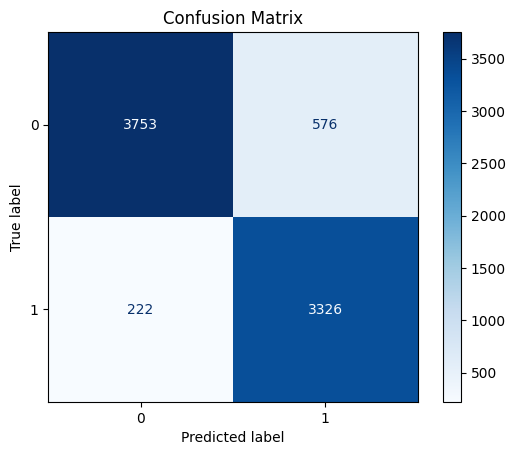

In [9]:
# call model and training
input_dim = 19        
hidden_dim = 8        
output_dim = 2    
window_size = 20      
dropout_prob = 0.5 
device = torch.device("cuda")
model = LSTMModel(input_dim, hidden_dim, output_dim, dropout_prob=dropout_prob, use_dense1=False)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
# scheduler = StepLR(optimizer, step_size=1)
best_val_loss = float('inf')  
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}
file_name = f"{WINDOW}_{OVERLAP}_{PCA_COMPONENTS}"
model_name = file_name + ".pth"
best_model_path = os.path.join(os.getcwd(), "output-milt", model_name)  
for epoch in range(1, num_epochs + 1):
    print(f"\nProcessing epoch number: {epoch}")
    train_loss, train_acc, train_preds, train_gts = train(model, device, train_loader, optimizer, epoch)
    print(f"Training Accuracy: {train_acc:.2f}% - Loss: {train_loss:.4f}")
    val_loss, val_acc, val_preds, val_gts = validation(model, device, val_loader)
    print(f"Validation Accuracy: {val_acc:.2f}% - Loss: {val_loss:.4f}")
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_best_model(model, optimizer, epoch, best_model_path)
        print(f"Best model updated at epoch {epoch} with loss {best_val_loss:.4f}")
# Save training history
history_name = file_name + ".npy"
history_file = os.path.join(os.getcwd(), "output-milt", history_name)
np.save(history_file, history)
print(f"\nTraining history saved at {history_file}")
cm_name = file_name + ".png"
test_and_save_confusion_matrix(model, device, test_loader, cm_name = cm_name)